## no_rag

### データセット

In [1]:
import json

with open("dataset/response.jsonl", "r") as f:
    res_data = [json.loads(l) for l in f.readlines()]
with open("dataset/source_info.jsonl", "r") as f:
    info_data = [json.loads(l) for l in f.readlines()]

In [48]:
id_list = [d["source_id"] for d in info_data]
len(id_list)

2965

In [49]:
train_data = []
test_data = []
for id in id_list:
    # reference
    for d in info_data[:]:
        if d["source_id"] == id:
            # print(d)
            task_type = d["task_type"]
            source = d["source"]
            ref = d["source_info"]
            info_data.remove(d)
            break
    # text
    num = 0
    for d2 in res_data[:]:
        if num == 6:
            break
        if d2["source_id"] == id:
            # print(d2)
            num += 1
            model_name = d2["model"]
            text = d2["response"]
            labels = 0 if d2["labels"] == [] else 1  # halってたら1
            data = {
                "ref": str(ref),
                "text": text,
                "labels": labels,
                "source": source,
                "model": model_name,
                "task_type": task_type,
                "source_id": id,
            }
            if d2["split"] == "train":
                train_data.append(data)
            else:
                test_data.append(data)
            res_data.remove(d2)

In [50]:
len(train_data), len(test_data)

(15090, 2700)

In [51]:
import json

with open("rag_truth_train.json", "w") as f:
    json.dump(train_data, f, indent=4)
with open("rag_truth_test.json", "w") as f:
    json.dump(test_data, f, indent=4)

### ここからでいい

In [1]:
import json

with open("rag_truth_train2.json", "r") as f:
    train_data = json.load(f)
with open("rag_truth_dev.json", "r") as f:
    dev_data = json.load(f)
with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)

In [2]:
# prefixをつける
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false: " + d["text"]
    return data


train_data = add_prefix(train_data)
dev_data = add_prefix(dev_data)
test_data = add_prefix(test_data)

In [16]:
# task_type: QA, Data2txt, Summary
task_name = "Summary"
train_data = [d for d in train_data if d["task_type"] == task_name]
dev_data = [d for d in dev_data if d["task_type"] == task_name]
test_data = [d for d in test_data if d["task_type"] == task_name]

In [3]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"train": train_ds, "dev":dev_ds, "test": test_ds})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 13830
    })
    dev: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 2700
    })
})

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding


tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
#tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
'''
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"
'''
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large",use_fast=False)


def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2025-01-02 23:56:49.104138: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 23:56:49.115563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-02 23:56:49.131716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-02 23:56:49.131754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 23:56:49.144086: I tensorflow/core/platform/cpu_feature_gua

Map:   0%|          | 0/13830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [5]:
from transformers import AutoModel

base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
#base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
#base_model = AutoModel.from_pretrained("meta-llama/Llama-2-7b-hf")
# base_model = AutoModel.from_pretrained("vinai/bertweet-large")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/RoBERTa-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import torch

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)
device

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


device(type='cuda')

In [8]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import ModelOutput
import os

loss_list = []


class NoRagModel(nn.Module):

    def __init__(self, base_model, question_encoder=None, generator=None):
        super(NoRagModel, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(base_model.config.hidden_size, 2)  # ラベル予測用の分類層
        #self.classifier = nn.Linear(96, 2)
        self.question_encoder = question_encoder
        self.generator = generator

    def forward(self, input_ids, attention_mask=None, labels=None):

        text_output = self.base_model(input_ids=input_ids, attention_mask=attention_mask)[1]
        #text_output = text_output.mean(dim=1)
        text_output = self.dropout(text_output)

        # ラベル予測の出力
        logits = self.classifier(text_output)

        loss = nn.CrossEntropyLoss()(logits, labels) if labels is not None else None
        loss_list.append(loss)
        return ModelOutput(logits=logits, loss=loss)

    def save_pretrained(self, save_directory):
        """
        モデル全体とサブモジュールを保存するカスタムメソッド
        """
        os.makedirs(save_directory, exist_ok=True)

        # サブモジュールの保存
        if self.question_encoder is not None:
            self.question_encoder.save_pretrained(os.path.join(save_directory, "question_encoder"))
        if self.generator is not None:
            self.generator.save_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みを保存
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def from_pretrained(cls, save_directory):
        """
        保存済みモデルをロードするカスタムメソッド
        """
        question_encoder = None
        generator = None

        # サブモジュールのロード
        if os.path.exists(os.path.join(save_directory, "question_encoder")):
            question_encoder = AutoModel.from_pretrained(os.path.join(save_directory, "question_encoder"))
        if os.path.exists(os.path.join(save_directory, "generator")):
            generator = AutoModel.from_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みをロード
        model = cls(question_encoder=question_encoder, generator=generator)
        model.load_state_dict(torch.load(os.path.join(save_directory, "pytorch_model.bin")))

        return model

In [9]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1).tolist()  # ndarray をリストに変換
    labels = labels.tolist()  # ndarray をリストに変換

    # accuracy と f1 score を計算
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}

In [10]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification
import torch
from torch.nn.parallel import DataParallel

# training_args = TrainingArguments("test-trainer")
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="steps",
    save_steps=10000,
    learning_rate=5e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=12,
    logging_dir="./logs",
    report_to="tensorboard",
)

# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model = NoRagModel(base_model)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/19755.1.interactive/ipykernel_788255/481541977.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.evaluate()

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6853256225585938,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.5753968253968254,
 'eval_recall': 0.0,
 'eval_precision': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 3.4886,
 'eval_samples_per_second': 361.18,
 'eval_steps_per_second': 90.295}

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Recall,Precision,F1
0,0.602000,0.567671,0.002400,0.723810,0.648598,0.684418,0.666027
1,0.528100,0.508669,0.002400,0.753968,0.629907,0.750557,0.684959
2,0.508600,0.507527,0.002400,0.759524,0.659813,0.744726,0.699703
3,0.486500,0.536560,0.002400,0.716667,0.773832,0.636923,0.698734
4,0.465700,0.500520,0.002400,0.763492,0.704673,0.729207,0.716730
6,0.429300,0.620005,0.002400,0.694444,0.837383,0.600536,0.699454
7,0.416400,0.545994,0.002400,0.738889,0.770093,0.666667,0.714657
8,0.402000,0.652877,0.002400,0.681746,0.856075,0.585678,0.695520
9,0.394800,0.623687,0.002400,0.694444,0.826168,0.602180,0.696612


TrainOutput(global_step=2880, training_loss=0.46822187635633683, metrics={'train_runtime': 730.9489, 'train_samples_per_second': 189.206, 'train_steps_per_second': 3.94, 'total_flos': 0.0, 'train_loss': 0.46822187635633683, 'epoch': 9.994216310005784})

In [13]:
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

{'eval_loss': 0.7013115882873535,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.6814814814814815,
 'eval_recall': 0.8271474019088016,
 'eval_precision': 0.5280974949221394,
 'eval_f1': 0.6446280991735537,
 'eval_runtime': 4.9095,
 'eval_samples_per_second': 549.957,
 'eval_steps_per_second': 137.489,
 'epoch': 9.994216310005784}

In [14]:
def create_dev_task(name):
    dev_data2 = [d for d in test_data if d["task_type"] == name]
    dev_df2 = pd.DataFrame(dev_data2)
    dev_ds2 = Dataset.from_pandas(dev_df2)
    tokenized_datasets_task = dev_ds2.map(tokenize_function, batched=True)
    tokenized_datasets_task = tokenized_datasets_task.remove_columns(["text"])
    return tokenized_datasets_task

In [15]:
dev_qa = create_dev_task("QA")
trainer.evaluate(eval_dataset=dev_qa)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.776752233505249,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.6344444444444445,
 'eval_recall': 0.76875,
 'eval_precision': 0.2963855421686747,
 'eval_f1': 0.42782608695652175,
 'eval_runtime': 1.8186,
 'eval_samples_per_second': 494.891,
 'eval_steps_per_second': 123.723,
 'epoch': 9.994216310005784}

In [16]:
dev_d2t = create_dev_task("Data2txt")
trainer.evaluate(eval_dataset=dev_d2t)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.6494220495223999,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.7677777777777778,
 'eval_recall': 0.9499136442141624,
 'eval_precision': 0.7534246575342466,
 'eval_f1': 0.8403361344537815,
 'eval_runtime': 1.8726,
 'eval_samples_per_second': 480.612,
 'eval_steps_per_second': 120.153,
 'epoch': 9.994216310005784}

In [17]:
dev_sum = create_dev_task("Summary")
trainer.evaluate(eval_dataset=dev_sum)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.6777603030204773,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.6422222222222222,
 'eval_recall': 0.5245098039215687,
 'eval_precision': 0.32228915662650603,
 'eval_f1': 0.39925373134328357,
 'eval_runtime': 1.776,
 'eval_samples_per_second': 506.769,
 'eval_steps_per_second': 126.692,
 'epoch': 9.994216310005784}

In [18]:
# トレーニング後にモデルを保存
name = "./0102_no_rag_rob"
trainer.save_model(name)
trainer.save_state()
model.save_pretrained(name)

In [ ]:
loss_list = [x.item() for x in loss_list]

In [14]:
len(loss_list)

126552

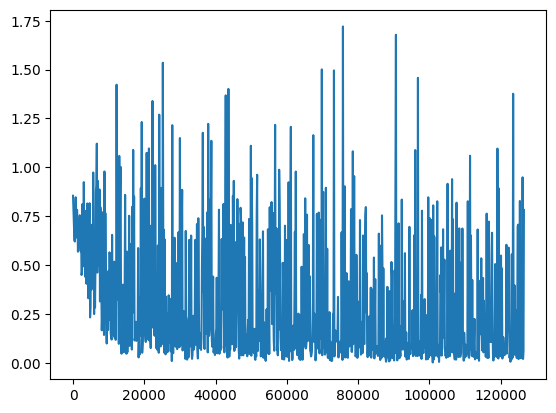

In [15]:
import matplotlib.pyplot as plt

x = np.arange(0, len(loss_list), len(loss_list) // 1000)
loss_list = np.array(loss_list)
plt.plot(x, loss_list[x])
plt.show()

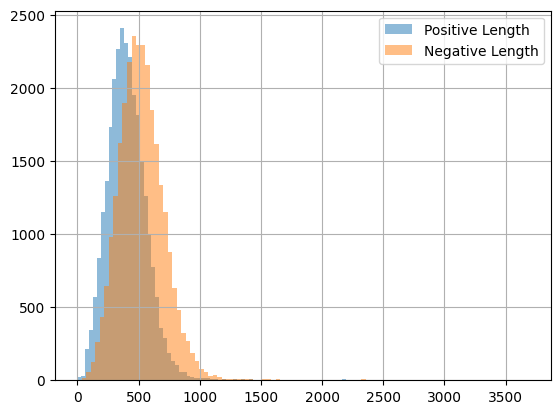

In [16]:
# 長さの分布
import matplotlib.pyplot as plt

train_true["text"].map(len).hist(alpha=0.5, label="Positive Length", bins=100)
train_false["text"].map(len).hist(alpha=0.5, label="Negative Length", bins=100)
plt.legend()
plt.show()

In [14]:
import torch
text = "I have a pen too"
tokenized_text = tokenizer(text)

# トークン化された結果の確認
#print(tokenized_text)

# input_ids と attention_mask を Tensor に変換
input_ids = torch.tensor(tokenized_text['input_ids']).unsqueeze(0).to(device)  # バッチ次元を追加
attention_mask = torch.tensor(tokenized_text['attention_mask']).unsqueeze(0).to(device)

# モデルに渡す
output = base_model(input_ids=input_ids, attention_mask=attention_mask)
print(output[0].shape)

torch.Size([1, 7, 768])


In [47]:
output[1][0][0].shape

torch.Size([1, 32, 4, 96])

In [30]:
trainer.save_model("./1213_no_rag_rob_sum")
trainer.save_state()
model.save_pretrained("./1213_no_rag_rob_sum")